# TP2 OpenMP et l'environnement de programmation EasyPAP
## M1 informatique, Université d'Orléans 2021/2022

*L'objectif de ce TP est de découvrir l'environnement de programmation [EasyPAP](https://gforgeron.gitlab.io/easypap/) et de l'utiliser pour approfondir la parallélisation par directives OpenMP.*

## 1. Installation et premier exemple avec EasyPAP

EasyPAP est un environnement de programmation qui offre des outils de visualisation permettant l'analyse du comportement du programme et de sa performance. Cet environnement permet de travailler sur des tableaux en 2 dimensions dont les éléments peuvent représenter les pixels d'une image.

Pour installer EasyPAP exécutez les étapes suivantes. **Faites-le !**
1. `$ git clone --depth 1 https://gitlab.com/gforgeron/easypap-se.git easypap`
1. extraire [images.zip](http://raymond.namyst.emi.u-bordeaux.fr/no_link/EasyPAP/images.zip) dans le répertoire `easypap/images`
1. placez vous dans le répertoire `easypap` et lancez la compilation avec `make`

### 1.1. Ça tourne !

EasyPAP est adapté à la programmation MPI (on verra ça plus tard) et la programmation graphique avec OpenCL (l'année prochaine). Pour lancez votre premier exemple vous allez utiliser le script `run` à la racine du dépôt. Exécutez la commande suivante (touche `Q` pour arrêter le programme)

```
$ ./run --kernel spin --variant seq 
```

EasyPAP travaille à partir de *kernels* qui permettent de définir des calculs sur des images. La variable prédéfinie `cur_img` correspond à l'image courante qui peut être modifiée et qui sera affichée. Par défaut sa taille est de 1024x1024 pixels. 

Exécutez la commande suivante

```
$ ./run --size 512 --kernel spin --variant seq --iterations 10 
```

qui peut aussi s'écrire de manière plus compacte comme ceci 

```
$ ./run -s 512 -k spin -v seq -i 10
```

Lorsqu'on travaille sur des données régulières, en particulier des tableaux, il est possible de découper ces données en bandes (ensemble de lignes, ensemble de colonnes) ou en blocs. EasyPAP permet de définir ce découpage en définissant des tuiles de taille `TILE_W` x `TILE_H`. Ces tailles peuvent être définies dans la commande `run` grâce aux options `--tile-width` (ou `-tw`) et `--tile-height` (ou `-th`) pour une tuile rectangulaire et `--tile-size` (ou `-ts`) pour une tuile carrée. Par défaut une tuile est carrée de taille 32 x 32.


```
$ ./run --kernel spin --variant tiled  
```

### 1.2. Ceci est un cours de parallélisme !

Pour le moment dans `spin.c` il n'y a que des versions séquentielles du calcul itératif de mise à jour de l'image.

~~~c++
unsigned spin_compute_omp (unsigned nb_iter)
{
  for (unsigned it = 1; it <= nb_iter; it++) {
    // Rajouter ici la directive OpenMP 
    for (int i = 0; i < DIM; i++)
      for (int j = 0; j < DIM; j++)
        cur_img (i, j) = compute_color (i, j);

    rotate ();
  }

  return 0;
}
~~~

~~~c++
unsigned spin_compute_omp_tiled (unsigned nb_iter)
{
  for (unsigned it = 1; it <= nb_iter; it++) {
    // directive ici 
    for (int y = 0; y < DIM; y += TILE_H)
    // ou ici
      for (int x = 0; x < DIM; x += TILE_W)
        do_tile (x, y, TILE_W, TILE_H, 0 /* CPU id */);

    rotate ();
  }

  return 0;
}
~~~

## 2. La transformation du boulanger

### 2.1. Parallélisation en boucle

Dans cette partie, vous allez ajouter un nouveau *kernel* à EasyPAP qui met en œuvre la transformation du boulanger discrète telle que décrite dans l'article [Images brouillées, images retrouvées](http://www.lifl.fr/~jdelahay/dnalor/ImagesBrouillees.pdf) par J-P. Delahaye et Ph. Mathieu.

Cette transformation consiste à suivre les étapes du boulanger qui étire et replie sa pâte plusieurs fois pour le pétrir. Sur une image si on itére cette transformation les pixels sont *brouillés* mais au bout d'un certain nombre d'itérations on retrouve l'image initiale (les pixels sont *débrouillés*). 

$$
\operatorname{next\_img}(i,2y+j) = 
\begin{cases}
\operatorname{cur\_img}(2i+j, y) &\mbox{si}& i < h \\
\operatorname{cur\_img}(4h-2i-j-1, 2w-y-1) &\mbox{sinon} &
\end{cases}
$$
avec $w$ la demi-largeur de l'image et $h$ la demi-hauteur de l'image (qui est donc de taille $2w \times 2h$.

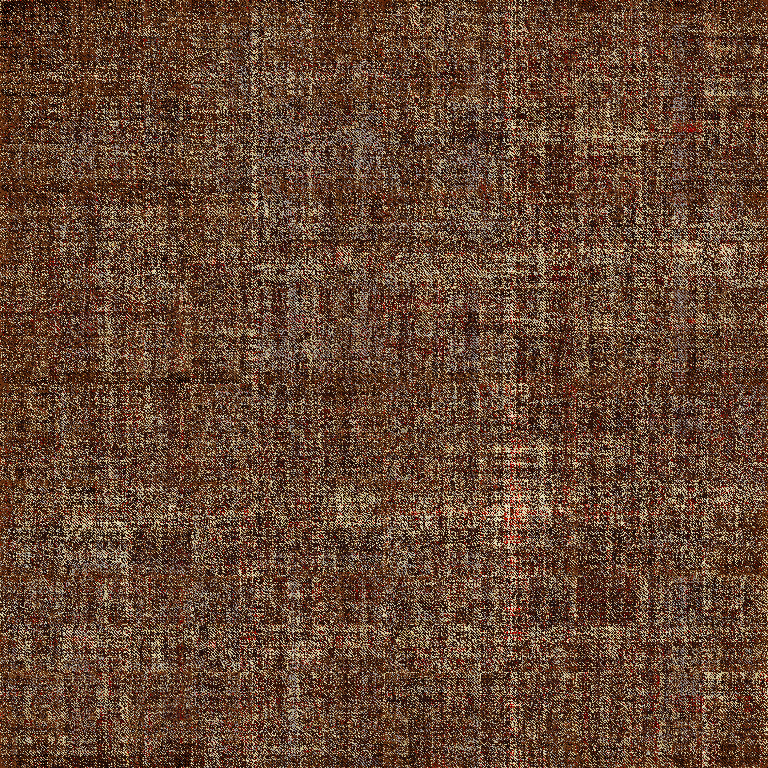
Voici un exemple d'image sur laquelle on souhaite effectuer 1000 itérations !


~~~c
unsigned baker_compute_seq (unsigned nb_iter)
{
    for (unsigned it = 1; it <= nb_iter; it++) {
        int w = DIM/2;
        int h = DIM/2;
        for (int i = 0; i < DIM; i++) {
            for (int j = 0; j < DIM; j++) {
                float x1 = j/2;
                float x2 = j%2;
                if(i<h){
                    next_img(i,j)=cur_img(2*i+x2,x1);
                }else{
                    next_img(i,j)=cur_img(4*h-2*i-x2-1,2*w-x1-1);
                }
            }
        }


        swap_images (); // fonction de EasyPAP permettant de faire le swap de cur_img et next_img
    }
    return 0;
}
~~~

~~~c++
unsigned baker_compute_seq (unsigned nb_iter)
{
    for (unsigned it = 1; it <= nb_iter; it++) {

     // à compléter en utilisant cur_img et next_img
        
        
    swap_images (); // fonction de EasyPAP permettant de faire le swap de cur_img et next_img
  }
   return 0;
}
~~~

~~~c++
unsigned baker_compute_omp (unsigned nb_iter); // Version parallèle sans tuiles
unsigned baker_compute_tiled (unsigned nb_iter); // Eventuellement une version séquentielle en utilisant les tuiles 
unsigned baker_compute_omp_tiled (unsigned nb_iter); // Version parallèle avec tuiles
~~~

### 2.2. Couper les coins pour aller plus vite

Le temps de retour, c'est-à-dire le temps que met l'image pour revenir à l'image initiale après application de la transformation du boulanger, peut être très long. Pour rejoindre une image lointaine (par exemple celle obtenue après 18328173 itérations) une simple itération de la transformation est inefficace (à moins de disposer de plusieurs années de calcul devant soi). Heureusement, chacun des pixels de l'image parcourt un cycle de valeurs de longueur limitée (au plus le nombre de pixels de l'image).

Ainsi, pour calculer l'image à un instant $T$ donnée, il suffit pour chaque pixel $(i,j)$ de trouver la longueur $C$ de son cycle puis de calculer le pixel obtenu en $(i,j)$ au bout de $T \pmod{C}$ étapes.

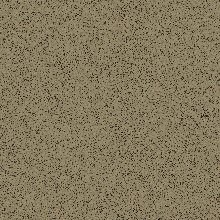
Voici un exemple d'image sur laquelle on souhaite effectuer 126661429 itérations !


~~~c++
unsigned baker_compute_corners (unsigned nb_iter); // Version séquentielle sans tuiles
unsigned baker_compute_corners_omp (unsigned nb_iter); // Version parallèle sans tuiles
unsigned baker_compute_corners_tiled (unsigned nb_iter); // Eventuellement une version séquentielle en utilisant les tuiles 
unsigned baker_compute_corners_omp_tiled (unsigned nb_iter); // Version parallèle avec tuiles
~~~

## Références

 1. [Spécification OpenMP](https://www.openmp.org/specifications/)
 1. [OpenMP Reference Guide](https://www.openmp.org/resources/refguides/)
 1. [Documentation officielle d'EasyPAP](https://gforgeron.gitlab.io/easypap/doc/Getting_Started.pdf)
 1. [Images brouillées, images retrouvées](http://www.lifl.fr/~jdelahay/dnalor/ImagesBrouillees.pdf)